In [1]:
include("../src/init.jl")
include("../src/fct.jl")
include("../src/fitting-fct.jl")
include("../src/worker_fct.jl")
data_type = "cal"
dataset = "v07.01"
set = "data"
# datasets = [
#     [53,64],
#     [65,79],
#     [80,92],
#     [93,113]
# ]
# datasets_str = [
#     "0053-0064",
#     "0065-0079",
#     "0080-0092",
#     "0093-0113"
# ]

"data"

In [2]:
ch = 34
ch_str = lpad(ch, 2, "0");

plots_path = "../plots/calib/" *ch_str * "-" * ctn[ch] * "/" * set * "/"
base_path  = "../../waveforms/calib/v07.01/"
base_path_AE  = "../../waveforms/data/calib_AE/"

calib_filepath = "../dicts/calib.json"
det_lib = JSON.parsefile("../dicts/det_lib.json")
if !isfile(calib_filepath)
    open(calib_filepath, "w") do f
        JSON.print(f, Dict(), 4)
    end
    calib = Dict()
else
    calib = JSON.parsefile(calib_filepath)
end

photon_lines = [583.2, 727.3, 860.6, 1592.5, 1620.7, 2103.5, 2614.5]; # keV


ds = det_lib[ctn[ch]]["ds"]

high_cut = 4
set = "data";
calib = JSON.parsefile(calib_filepath)
if !haskey(calib, ctn[ch])
    calib[ctn[ch]] = Dict()
    calib[ctn[ch]]["data"] = Dict()
    calib[ctn[ch]]["sim"] = Dict()
end
filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
isfile(filepath)

true

In [24]:
ctn[35]

"GD89A"

In [22]:
ch = 0
calib[ctn[ch]]["data"]["fits"]["peaks_first_cal"]["1592.5"][1]["σ"]

1.4239750675766878

In [23]:
calib[ctn[ch]]["data"]["fits"]["peaks_gerda_cal"]["1592.5"][1]["σ"]

0.9438723849138017

In [18]:
# wf = []
filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
!isdir(dirname(filepath)) ? mkpath(dirname(filepath)) : ""
if !isfile(filepath)
    
    files = glob(joinpath(base_path, ch_str * "-" * ctn[ch] * "/*.h5"));
    
    numofele = 5
    BackDelta5 = div(numofele,2)
    ForwardDelta5 = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    numofele = 201
    BackDelta201 = div(numofele,2)
    ForwardDelta201 = isodd(numofele) ? div(numofele,2) : div(numofele,2) - 1
    
    all_data = Table(energy = [], run = [], channel = [], AoEvetoed = [], datasetID = [], AoEclassifier = [], A = [], E = [])
    @showprogress 1 "Read data..." for file in files
        tmp = HDF5.h5open(file, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end
        tmp = tmp |> @filter(datasets[ds][1] <= _.run <= datasets[ds][2]) |> Table
        if channel_to_bege[ch] && ch != 6 && ch != 13
            if 0 in unique(tmp.datasetID)
                tmp = tmp |> @filter(_.datasetID == 0) |> Table
#                 wf = tmp.waveform
#                 return wf
                A = []
                E = []
                for wf in tmp.waveform
                    push!(A, maximum(movingaverage(diff(wf.value),5,BackDelta5,ForwardDelta5,3)))
                    push!(E, maximum(movingaverage(diff(wf.value),201,BackDelta201,ForwardDelta201,13)))
#                     push!(A, maximum(mwa(diff(wf.value),5,3)))
#                     push!(E, maximum(mwa(diff(wf.value),201,13)))
                end
                if size(tmp,1) > 1
                    append!(all_data, Table(energy = tmp.energy, run = tmp.run, channel = tmp.channel, AoEvetoed = tmp.AoEvetoed, datasetID = tmp.datasetID, AoEclassifier = tmp.AoEclassifier, A = A, E = E))
                end
            end
        else
            A = []
            E = []
            for wf in tmp.waveform
                push!(A, maximum(movingaverage(diff(wf.value),5,BackDelta5,ForwardDelta5,3)))
                push!(E, maximum(movingaverage(diff(wf.value),201,BackDelta201,ForwardDelta201,13)))
#                 push!(A, maximum(mwa(diff(wf.value),5,3)))
#                 push!(E, maximum(mwa(diff(wf.value),201,13)))
            end
            if size(tmp,1) > 1
                append!(all_data, Table(energy = tmp.energy, run = tmp.run, channel = tmp.channel, AoEvetoed = tmp.AoEvetoed, datasetID = tmp.datasetID, AoEclassifier = tmp.AoEclassifier, A = A, E = E))
            end
        end    
    end

    HDF5.h5open(filepath, "w") do h5f
        LegendHDF5IO.writedata(h5f, "data", Table(
            A = float.(all_data.A),
            E = float.(all_data.E),
            run = Array{Int64, 1}(all_data.run),
            AoEvetoed = Array{Int64, 1}(all_data.AoEvetoed),
            datasetID = Array{Int64, 1}(all_data.datasetID),
            AoEclassifier = float.(all_data.AoEclassifier),
            energy = float.(all_data.energy)
        ))
    end
end
all_data = nothing
data = HDF5.h5open(filepath, "r") do h5f
    LegendHDF5IO.readdata(h5f, "data")
end
data = data |> @filter(_.run in calib[channel_to_name[ch]][set]["used_runs"]) |> Table

Table with 7 columns and 1428098 rows:
      A        E        run  AoEvetoed  datasetID  AoEclassifier  energy
    ┌────────────────────────────────────────────────────────────────────
 1  │ 168.624  3.48112  85   1          0          31.0018        873.472
 2  │ 183.024  5.07422  85   0          0          -1.3057        1274.43
 3  │ 269.056  7.33827  85   0          0          0.721652       1842.8
 4  │ 166.056  6.8473   85   1          0          -46.3689       1721.37
 5  │ 67.144   1.90697  85   0          0          -1.0719        468.957
 6  │ 86.08    2.33767  85   0          0          0.604783       583.75
 7  │ 54.216   1.62809  85   0          0          -0.333473      374.514
 8  │ 163.864  4.44593  85   0          0          1.2345         1117.48
 9  │ 239.6    7.88487  85   1          0          -24.4522       1983.51
 10 │ 49.416   2.07448  85   1          0          -21.1828       517.048
 11 │ 368.096  10.4204  85   1          0          -4.13615       2616.82
 1

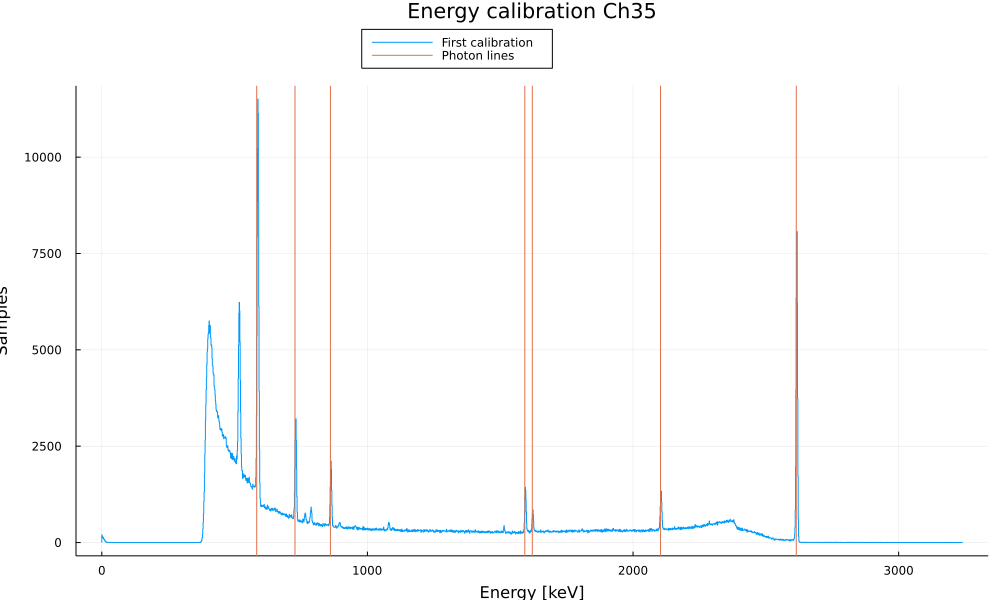

In [782]:
if haskey(calib[ctn[ch]][set], "uncal_range")
    before = calib[ctn[ch]][set]["uncal_range"]["start"]:calib[ctn[ch]][set]["uncal_range"]["step"]:calib[ctn[ch]][set]["uncal_range"]["end"]
else 
    before = 0.0:0.005:13
end


h_uncal = fit(Histogram, float.(data.E), before)
p = plot(h_uncal, st=:step)
h_cal, h_deconv, peakPositions, threshold, c, c_precal = RadiationSpectra.calibrate_spectrum(h_uncal, photon_lines)      
p = plot(h_cal, st=:step, label="First calibration")
p = vline!(photon_lines, label="Photon lines")
p = plot!(xlabel="Energy [keV]", ylabel="Samples", title="Energy calibration Ch$ch_str", legend=:outertop, size=(1000,600))
filename = joinpath(plots_path, "E_first-cal.pdf")
!isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
savefig(p, filename)
p

In [783]:
calib[ctn[ch]][set]["events"]      = size(data,1)
calib[ctn[ch]][set]["first_cal"]   = c
calib[ctn[ch]][set]["uncal_range"] = Dict()
calib[ctn[ch]][set]["uncal_range"]["start"] = before[1]
calib[ctn[ch]][set]["uncal_range"]["end"]   = before[end]
calib[ctn[ch]][set]["uncal_range"]["step"]  = round((before[end] - before[1]) / length(before), digits=4)
open(calib_filepath, "w") do f
    JSON.print(f, calib, 4)
end

### Fit peaks (without offset)

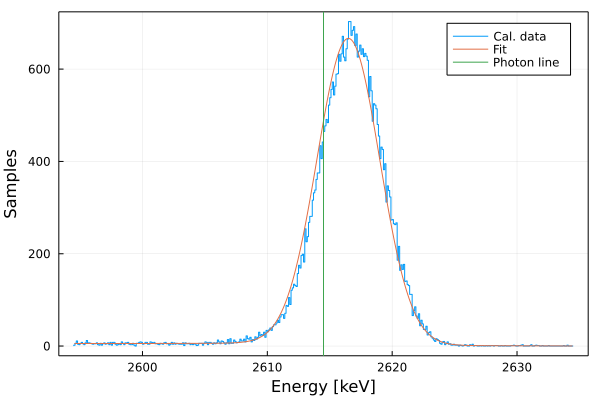

(n = 5528.475276305288, σ = 2.50654936645984, μ = 2616.4999161619958, bkg_l = 4.791522504513023, bkg_r = 0.2526869687306976, c = 78.66034477292766, d = 1.7162983712552848, β = 9.75139482560832)


In [784]:
calib = JSON.parsefile(calib_filepath)
if length(data.E) > 0
#     for pl in [photon_lines[1]]
    for pl in photon_lines
        rng_step  = 0.1
        rng_width = 20
        c = calib[ctn[ch]][set]["first_cal"]
        E = data.E .* c
        rng = pl-rng_width:rng_step:pl+rng_width
        h_peak = fit(Histogram, E, rng)

        
        bkg_l_mean = mean(h_peak.weights[1:20])
        bkg_r_mean = mean(h_peak.weights[end-20:end])
        if pl == 1592.5
            prior = NamedTupleDist(
                n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
                σ = 0.5..3,
                μ = pl-1..pl+1,
                bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
                bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
                c = 0..2e2,
                d = 0..10.0,
                β = 0.1..10.0
            )
            ff = peak
#         elseif pl == 2614.5
#             prior = NamedTupleDist(
#                 n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
#                 σ = 1.0..1.8,
#                 μ = pl-1..pl+1,
#                 bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
#                 bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
#                 c = 0..3e3,
#                 d = 0..10.0,
#                 β = 0.1..10.0,
#                 n2 = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
#                 σ2 = 1.8..4
#             )
#             ff = broad_peak
        elseif pl in [583.2, 727.3]
            prior = NamedTupleDist(
                n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
#                 n = 0.0..1.0,
                σ = 1.0..3.0,
                μ = pl-1..pl+4,
                bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
                bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
                c = 0..1e4,
#                 c = 0.0..1.0,
                d = 1.0..50.0,
                β = 0.1..10.0
            )
            ff = peak
        else
            prior = NamedTupleDist(
                n = sum(h_peak.weights)/100..sum(h_peak.weights),
                σ = 0.5..3,
                μ = pl-2..pl+2,
                bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
                bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
                c = 0..2e3,
                d = 0..10.0,
                β = 0.1..10.0
            )
            ff = peak
        end
        fail = false
        @info("First try $pl keV")
        samples = try bat_fit(h_peak, ff, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=true)
            catch 
            IJulia.clear_output(true)
            @info("Second try $pl keV")
            try bat_fit(h_peak, ff, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=true)
                catch 
                IJulia.clear_output(true)
                @info("Last try $pl keV")
                try bat_fit(h_peak, ff, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=true)
                    catch 
                    IJulia.clear_output(true)
                    fail = true
                end
            end
        end
        if fail == false
            v, e = mode(samples), std(samples)
            x_fit = midpoints(h_peak.edges[1])
            y_fit = ff(x_fit, v)
            y_fit ./= sum(y_fit)
            y_fit .*= sum(h_peak.weights)
            p = plot(h_peak, st=:step, label="Cal. data")
            p = plot!(x_fit, y_fit, label="Fit")
            p = plot!(xlabel="Energy [keV]", ylabel="Samples", legend=:topright, framestyle=:box)
            p = vline!([pl], label="Photon line")
            filename = joinpath(plots_path, "peaks/$pl keV line-first.pdf")
            !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
            savefig(p, filename)
            IJulia.clear_output(true)
            display(p)
            !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
            !haskey(calib[ctn[ch]][set]["fits"], "peaks_first_cal") ? calib[ctn[ch]][set]["fits"]["peaks_first_cal"] = Dict() : ""
            calib[ctn[ch]][set]["fits"]["peaks_first_cal"][string(pl)] = [v,e]
            println(v)
        else
            @info("Fail for $pl keV line")
            !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
            !haskey(calib[ctn[ch]][set]["fits"], "peaks_first_cal") ? calib[ctn[ch]][set]["fits"]["peaks_first_cal"] = Dict() : ""
            calib[ctn[ch]][set]["fits"]["peaks_first_cal"][string(pl)] = [[], []]
        end
        open(calib_filepath, "w") do f
            JSON.print(f, calib, 4)
        end
    end
end

In [785]:
# 1
calib[ctn[ch]][set]["fits"]["peaks_first_cal"]#[string(photon_lines[1])]

Dict{Any, Any} with 7 entries:
  "2614.5" => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "727.3"  => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "860.6"  => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "1592.5" => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "583.2"  => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "1620.7" => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "2103.5" => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…

# Linear energy calibration for offset

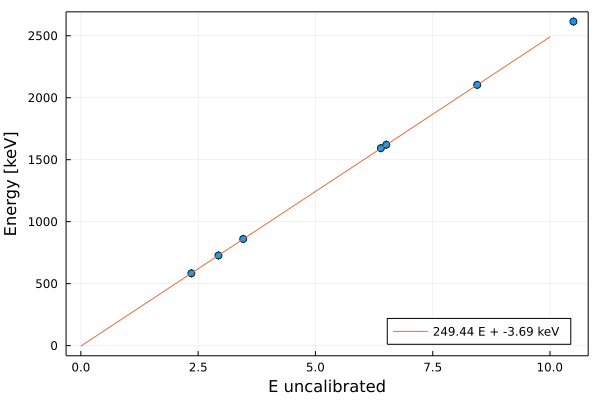

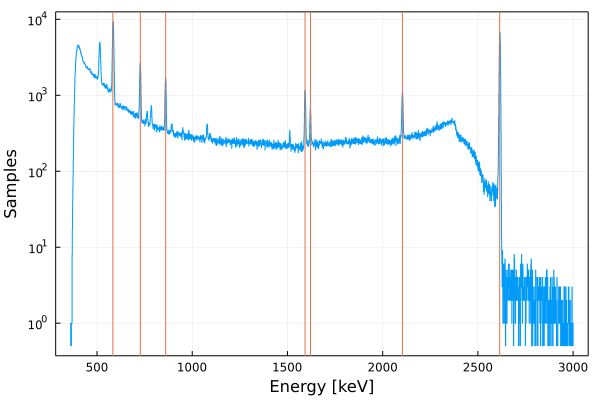

In [786]:
calib = JSON.parsefile(calib_filepath)
pos_pl  = []
pos     = []
pos_err = []
c = calib[ctn[ch]][set]["first_cal"]
for (k,v) in calib[ctn[ch]][set]["fits"]["peaks_first_cal"]
    push!(pos_pl, parse(Float64, k))
    push!(pos, v[1]["μ"] / c)
    push!(pos_err, v[2]["μ"] / c)
end
p0 = [c, .0]
f = curve_fit(linmodel, pos, pos_pl, p0)
par = f.param
err = margin_error(f)
p = scatter(pos, pos_pl, xerr=pos_err, label="")
x = 0:0.5:maximum(pos)
p = plot!(x, linmodel(x, par), label=string(round(par[1], digits=2)) * " E + " * string(round(par[2], digits=2)) * " keV")
p = plot!(xlabel="E uncalibrated", ylabel="Energy [keV]", legend=:bottomright, framestyle=:box)
filename = joinpath(plots_path, "linear-energy-fit.pdf")
savefig(p, filename)
display(p)
calib[ctn[ch]][set]["lin_cal"] = [par, err]
open(calib_filepath, "w") do f
    JSON.print(f, calib, 4)
end
E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
h_cal = fit(Histogram, E, 300:1:3000)
p = plot(h_cal, st=:step, label="", yaxis=:log)
p = vline!(photon_lines, label="")
p = plot!(ylabel="Samples", xlabel="Energy [keV]", framestyle=:box)
filename = joinpath(plots_path,"linear-cal-energy-spectrum.pdf")
savefig(p, filename)
display(p)

### Fit peaks (with offset)
Not needed

In [787]:
# calib = JSON.parsefile(calib_filepath)
# if length(data.E) > 0
#     E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
#     for pl in photon_lines
#         rng_step  = 0.1
#         rng_width = 20
#         c = calib[ctn[ch]][set]["first_cal"]
#         rng = pl-rng_width:rng_step:pl+rng_width
#         h_peak = fit(Histogram, E, rng)

        
#         bkg_l_mean = mean(h_peak.weights[1:20])
#         bkg_r_mean = mean(h_peak.weights[end-20:end])
#         if pl == 1592.5
#             prior = NamedTupleDist(
#                 n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
#                 σ = 5e-1..3,
#                 μ = pl-1..pl+1,
#                 bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
#                 bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
#                 c = 0..2e2,
#                 d = 0..10.0,
#                 β = 0.1..10.0
#             )
#             ff = peak
#         elseif pl == 2614.5
#             prior = NamedTupleDist(
#                 n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
#                 σ = 1.0..1.8,
#                 μ = pl-1..pl+1,
#                 bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
#                 bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
#                 c = 0..3e3,
#                 d = 0..10.0,
#                 β = 0.1..10.0,
#                 n2 = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
#                 σ2 = 1.8..4
#             )
#             ff = broad_peak
#         else
#             prior = NamedTupleDist(
#                 n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
#                 σ = 5e-1..3,
#                 μ = pl-1..pl+1,
#                 bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
#                 bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
#                 c = 0..2e3,
#                 d = 0..10.0,
#                 β = 0.1..10.0
#             )
#             ff = peak
#         end
#         fail = false
#         samples = try bat_fit(h_peak, ff, prior; nsamples=1*10^5, nchains=4, params_first=false)
#             catch 
#             try bat_fit(h_peak, ff, prior; nsamples=1*10^5, nchains=4, params_first=false)
#                 catch 
#                 try bat_fit(h_peak, ff, prior; nsamples=1*10^5, nchains=4, params_first=false)
#                     catch 
#                     fail = true
#                 end
#             end
#         end
#         if fail == false
#             v = mean(samples)[1]
#             x_fit = midpoints(h_peak.edges[1])
#             y_fit = ff(x_fit, v)
#             y_fit ./= sum(y_fit)
#             y_fit .*= sum(h_peak.weights)
#             p = plot(h_peak, st=:step, label="Cal. data")
#             p = plot!(x_fit, y_fit, label="Bat fit")
#             p = plot!(xlabel="Energy [keV]", ylabel="Samples", title="$pl keV line Ch$ch_str | run" * datasets_str[ds], legend=:outertop, size=(1000,600))
#             p = vline!([pl], label="Photon line")
#             filename = joinpath(plots_path, ch_str * "-" * ctn[ch] * "/" *set * "/run" * datasets_str[ds] * "/peaks/$pl keV line-linear.png")
#             !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
#             savefig(p, filename)
#             IJulia.clear_output(true)
#             display(p)
#             !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
#             !haskey(calib[ctn[ch]][set]["fits"], "peaks_cal") ? calib[ctn[ch]][set]["fits"]["peaks_cal"] = Dict() : ""
#             calib[ctn[ch]][set]["fits"]["peaks_cal"][string(pl)] = [mode(samples)[1], std(samples)[1]]
#         else
#             @info("Fail for $pl keV line")
#             !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
#             !haskey(calib[ctn[ch]][set]["fits"], "peaks_cal") ? calib[ctn[ch]][set]["fits"]["peaks_cal"] = Dict() : ""
#             calib[ctn[ch]][set]["fits"]["peaks_cal"][string(pl)] = [[], []]
#         end
#         open(calib_filepath, "w") do f
#             JSON.print(f, calib, 4)
#         end
#     end
# end

### Comparison to GERDA E calibration (using data.energy)
Not needed

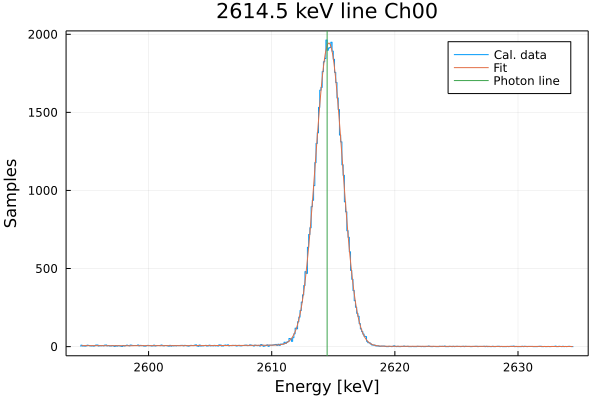

Ch00 | Fit peaks using GERDA calibration...100%|████████| Time: 0:02:40


In [19]:
calib = JSON.parsefile(calib_filepath)
if length(data.E) > 0
    E = data.energy
    @showprogress 1 "Ch" * ch_str * " | Fit peaks using GERDA calibration..." for pl in photon_lines
        rng_step  = 0.1
        rng_width = 20
        c = calib[ctn[ch]][set]["first_cal"]
        rng = pl-rng_width:rng_step:pl+rng_width
        h_peak = fit(Histogram, E, rng)

        
        p = plot(h_peak, st=:step, label="Cal. data")
#         display(p)
        bkg_l_mean = mean(h_peak.weights[1:20])
        bkg_r_mean = mean(h_peak.weights[end-20:end])
        if pl == 1592.5
            prior = NamedTupleDist(
                n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
                σ = 5e-1..3,
                μ = pl-1..pl+1,
                bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
                bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
                c = 0..2e2,
                d = 0..10.0,
                β = 0.1..10.0
            )
            ff = peak
#         elseif pl == 2614.5
#             prior = NamedTupleDist(
#                 n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
#                 σ = 1.0..1.8,
#                 μ = pl-1..pl+1,
#                 bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
#                 bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
#                 c = 0..3e3,
#                 d = 0..10.0,
#                 β = 0.1..10.0,
#                 n2 = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
#                 σ2 = 1.8..4
#             )
#             ff = broad_peak
        elseif pl == 860.6
            prior = NamedTupleDist(
                n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
                σ = 3e-1..3,
                μ = pl-1..pl+1,
                bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
                bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
                c = 0..1e2,
                d = 0..20.0,
                β = 0.1..10.0
            )
            ff = peak
        else
            prior = NamedTupleDist(
                n = sum(h_peak.weights)/100..sum(h_peak.weights)/10,
                σ = 5e-1..3,
                μ = pl-1..pl+1,
                bkg_l = bkg_l_mean *0.75..bkg_l_mean *1.5,
                bkg_r = bkg_r_mean *0.75..bkg_r_mean *1.5,
                c = 0..4e2,
                d = 0..10.0,
                β = 0.1..10.0
            )
            ff = peak
        end
        fail = false
        samples = try bat_fit(h_peak, ff, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=true)
            catch 
            try bat_fit(h_peak, ff, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false)
                catch 
                try bat_fit(h_peak, ff, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=true)
                    catch 
                    fail = true
                end
            end
        end
        if fail == false
            v = mean(samples)
            x_fit = midpoints(h_peak.edges[1])
            y_fit = ff(x_fit, v)
            y_fit ./= sum(y_fit)
            y_fit .*= sum(h_peak.weights)
            p = plot(h_peak, st=:step, label="Cal. data")
            p = plot!(x_fit, y_fit, label="Fit")
            p = plot!(xlabel="Energy [keV]", ylabel="Samples", title="$pl keV line Ch$ch_str", framestyle=:box)
            p = vline!([pl], label="Photon line")
            filename = joinpath(plots_path, "peaks/$pl keV line-gerda.pdf")
            !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
            savefig(p, filename)
            IJulia.clear_output(true)
            display(p)
            !haskey(calib[ctn[ch]][set]["fits"], "peaks_gerda_cal") ? calib[ctn[ch]][set]["fits"]["peaks_gerda_cal"] = Dict() : ""
            calib[ctn[ch]][set]["fits"]["peaks_gerda_cal"][string(pl)] = [mode(samples), std(samples)]
        else
            @info("Fail for $pl keV line")
            !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
            !haskey(calib[ctn[ch]][set]["fits"], "peaks_gerda_cal") ? calib[ctn[ch]][set]["fits"]["peaks_gerda_cal"] = Dict() : ""
            calib[ctn[ch]][set]["fits"]["peaks_gerda_cal"][string(pl)] = [[], []]
        end
        open(calib_filepath, "w") do f
            JSON.print(f, calib, 4)
        end
    end
end

In [20]:
calib[ctn[ch]][set]["fits"]["peaks_gerda_cal"]

Dict{Any, Any} with 7 entries:
  "2614.5" => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "727.3"  => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "860.6"  => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "1592.5" => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "583.2"  => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "1620.7" => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…
  "2103.5" => NamedTuple{(:n, :σ, :μ, :bkg_l, :bkg_r, :c, :d, :β), NTuple{8, Fl…

# A/E calibration

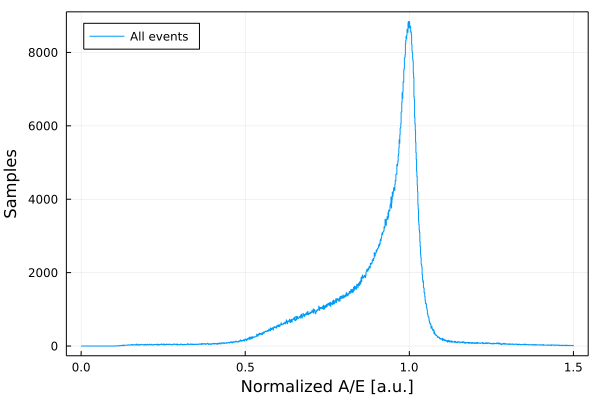

In [790]:
calib = JSON.parsefile(calib_filepath)
E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
A = deepcopy(data.A)
AoE = A ./ E
h = fit(Histogram, AoE, 0:0.0001:0.3)
AE_norm = h.edges[1][findfirst(x->x == maximum(h.weights), h.weights)]
AoE ./= AE_norm
h = fit(Histogram, AoE, 0:0.001:1.5)
calib[ctn[ch]][set]["AE_norm"] = AE_norm
open(calib_filepath, "w") do f
    JSON.print(f, calib, 4)
end
p = plot(h, st=:step, label="All events")
p = plot!(xlabel="Normalized A/E [a.u.]", ylabel="Samples", legend=:topleft, framestyle=:box)
filename = joinpath(plots_path, "AoverE_all-events_norm.pdf")
savefig(p, filename)
display(p)

# Energy spectrum

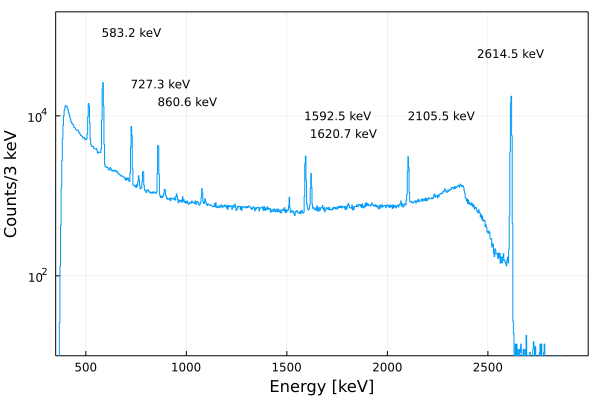

In [791]:
E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
h = fit(Histogram, E, 350:3:3000)
photon_lines = [583.2, 727.3, 860.6, 1592.5, 1620.7, 2105.5, 2614.5]; # keV
p = plot(h, st=:step, yscale=:log10, ylim=(1e1,2e5), xlim=(minimum(h.edges[1]),maximum(h.edges[1])))
p = annotate!(583.2, 1.1e5, text("583.2 keV", :black, :left, 8))
p = annotate!(727.3, 2.5e4, text("727.3 keV", :black, :left, 8))
p = annotate!(860.6, 1.5e4, text("860.6 keV", :black, :left, 8))
p = annotate!(1592.5, 1e4, text("1592.5 keV", :black, :left, 8))
p = annotate!(1620.7, 6e3, text("1620.7 keV", :black, :left, 8))
p = annotate!(2105.5, 1e4, text("2105.5 keV", :black, :left, 8))
p = annotate!(2614.5, 6e4, text("2614.5 keV", :black, 8))
p = plot!(legend=false, framestyle=:box, xlabel="Energy [keV]", ylabel="Counts/3 keV")
filename = joinpath(plots_path, "energy_spectrum.pdf")
savefig(p, filename)
display(p)

# A/E slice fits

In [3]:
# Done:
ch = 34
ch_str = lpad(ch, 2, "0");

plots_path = "../plots/calib/" *ch_str * "-" * ctn[ch] * "/" * set * "/"
base_path  = "../../waveforms/calib/v07.01/"
base_path_AE  = "../../waveforms/data/calib_AE/"

calib_filepath = "../dicts/calib.json"
calib = JSON.parsefile(calib_filepath)
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = JSON.parsefile(cut_lib_filepath)
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = JSON.parsefile(AE_cal_filepath)

high_cut = 4
set = "data";
calib = JSON.parsefile(calib_filepath)
if !haskey(calib, ctn[ch])
    calib[ctn[ch]] = Dict()
    calib[ctn[ch]]["data"] = Dict()
    calib[ctn[ch]]["sim"] = Dict()
end
filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
data = HDF5.h5open(filepath, "r") do h5f
    LegendHDF5IO.readdata(h5f, "data")
end;

In [4]:
slice_lib_filepath = "../dicts/slice_lib.json"
slice_filepath = "../dicts/slices/"
slices = [600, 630, 660, 800, 895, 925, 955, 985, 1015, 1045,
        1130, 1160, 1190, 1220, 1250, 1280, 1310, 1340, 1370, 1400, 1430, 1460, 1545,
        1665, 1695, 1725, 1755, 1785, 1815, 1845, 1875, 1905, 1935, 
        1965, 1995, 2025, 2055,
        2145, 2175, 2205, 2235, 2265, 2295, 2325];

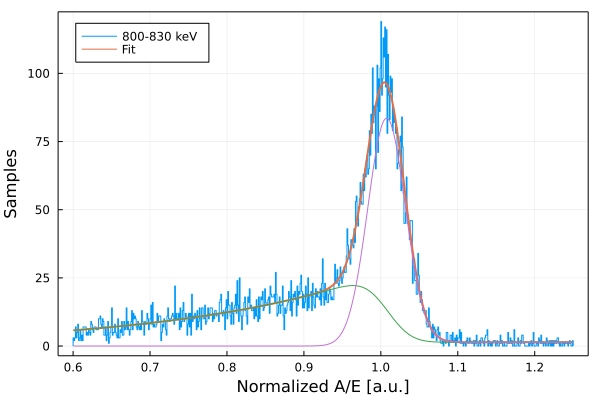

In [13]:
overwrite = true#false
fails = Dict()
for ch in 0:1:36
    if !ctb[ch] || ch in [5,6,7,34]
        continue
    end
    ch_str = lpad(ch, 2, "0");

    plots_path = "../plots/calib/" *ch_str * "-" * ctn[ch] * "/" * set * "/"
    base_path  = "../../waveforms/calib/v07.01/"
    base_path_AE  = "../../waveforms/data/calib_AE/"

    calib_filepath = "../dicts/calib.json"
    calib = JSON.parsefile(calib_filepath)
    cut_lib_filepath = "../dicts/cut_lib.json"
    cut_lib = JSON.parsefile(cut_lib_filepath)
    AE_cal_filepath = "../dicts/AE_cal.json"
    AE_cal = JSON.parsefile(AE_cal_filepath)

    high_cut = 4
    set = "data";
    calib = JSON.parsefile(calib_filepath)
    if !haskey(calib, ctn[ch])
        calib[ctn[ch]] = Dict()
        calib[ctn[ch]]["data"] = Dict()
        calib[ctn[ch]]["sim"] = Dict()
    end
    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
    data = HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    for slice in eachindex(slices)[1:4]
        slice_lib_filepath = joinpath(slice_filepath, ch_str * "/" * lpad(slices[slice], 4, "0") * ".json")
        if !isfile(slice_lib_filepath) || overwrite
            slice_lib = Dict()
            !haskey(slice_lib, ctn[ch]) ? slice_lib[ctn[ch]] = Dict() : ""
            !haskey(slice_lib[ctn[ch]], set) ? slice_lib[ctn[ch]][set] = Dict() : ""
            !haskey(slice_lib[ctn[ch]][set], "AE_slices") ? slice_lib[ctn[ch]][set]["AE_slices"] = Dict() : ""

            !isdir(dirname(slice_lib_filepath)) ? mkpath(dirname(slice_lib_filepath)) : ""
            open(slice_lib_filepath, "w") do f
                JSON.print(f, slice_lib, 4)
            end
            slice_lib = JSON.parsefile(slice_lib_filepath)
            calib = JSON.parsefile(calib_filepath)
            @info("Start fitting slice " * string(slice) * " of " * string(length(slices)) * " | Detector: Ch" * ch_str * " - " * ctn[ch] * " ($set)")

            E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
            A = deepcopy(data.A)
            AoE = A ./ E
            AoE ./= calib[ctn[ch]][set]["AE_norm"]
            index = findall(x -> x >= slices[slice] && x < slices[slice] + 30, E);
            rng_start = 0.7
            rng_end = 1.25
            h = fit(Histogram, AoE[index], rng_start-0.1:0.001:rng_end);


            ################################################################
            #
            # Fit 1
            #
            ################################################################
    #         prior = NamedTupleDist(
    #             scale = sum(h.weights)/5..sum(h.weights),
    #             σ     = 1e-3..std(AoE[index][findall(x->x >0.93 && x < 1.07, AoE[index])]),
    #             μ     = 0.98..1.01,
    #             C     = sum(h.weights)/5..sum(h.weights)*10,#1e3..1e5,
    #             l     = 0.99..1.0,
    #             e     = 2..70,
    #             t     = 100..2e3
    #         )
    #         fail = false
    #         IJulia.clear_output(true)
    #         @info("Start fitting slice " * string(slice) * " of " * string(length(slices)) * " | Detector: Ch" * ch_str * " - " * ctn[ch] * " ($set)")
    #         samples = try bat_fit(h, tail_model, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=true);
    #         catch
    #             try bat_fit(h, tail_model, prior; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=true);
    #             catch
    #                 try bat_fit(h, tail_model, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=true);
    #                 catch
    #                     fail = true
    #                 end
    #             end
    #         end
    #         p1 = plot();
    #         if !fail
    #             par, err = mode(samples), std(samples)

    #             x_fit = float.(midpoints(h.edges[1]))
    #             y_fit = tail_model(x_fit, par)
    #             y_fit ./= sum(y_fit)
    #             y_fit .*= sum(h.weights)

    #             par_tail = (scale = 0, σ = par.σ, μ = par.µ, C = par.C, l = par.l, e = par.e, t = par.t)
    #             y_tail = tail_model(x_fit, par_tail)
    #             y_tail ./= sum(y_tail)
    #             y_tail .*= (sum(tail_model(x_fit, par_tail)) / sum(tail_model(x_fit, par)))
    #             y_tail .*= sum(h.weights)

    #             par_gauss = (scale = par.scale, σ = par.σ, μ = par.µ, C = 0, l = par.l, e = par.e, t = par.t)
    #             y_gauss = tail_model(x_fit, par_gauss)
    #             y_gauss ./= sum(y_gauss)
    #             y_gauss .*= (sum(tail_model(x_fit, par_gauss)) / sum(tail_model(x_fit, par)))
    #             y_gauss .*= sum(h.weights)

    #             !haskey(slice_lib[ctn[ch]][set]["AE_slices"], string(slices[slice])) ? slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])] = Dict() : ""
    #             slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])]["tail"] = [par, err]
    #             slice_filepath
    #             open(slice_lib_filepath, "w") do f
    #                 JSON.print(f, slice_lib, 4)
    #             end
    #             E_range = string(slices[slice]) * "-" * string(slices[slice] + 30)
    #             p1 = plot!(h, st=:step, label=E_range * " keV");
    #             p1 = plot!(x_fit, y_fit, label="Fit", lw=2);
    #             p1 = plot!(x_fit, y_tail, label="");
    #             p1 = plot!(x_fit, y_gauss, label="");
    #             p1 = plot!(xlabel="Normalized A/E [a.u.]", ylabel="Samples", legend=:topleft, framestyle=:box);
    #             filename = joinpath(plots_base_path, "AE_slices/" * lpad(slices[slice], 4, "0") * "-tail_model.pdf")
    #             !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
    #             savefig(p1, filename);
    #             IJulia.clear_output(true)
    #             display(p1)
    #         end
            ################################################################
            #
            # Fit 2
            #
            ################################################################
            if slice > 1
                last_file = joinpath(slice_filepath, ch_str * "/" * lpad(slices[slice-1], 4, "0") * ".json")
                if isfile(last_file)
                    tmp = JSON.parsefile(last_file)
                    use_past = haskey(tmp[ctn[ch]], set)
                    if use_past
                        use_past = haskey(tmp[ctn[ch]][set]["AE_slices"], string(slices[slice - 1]))
                    end
                else
                    use_past = false
                    last_file = joinpath(slice_filepath, ch_str * "/" * lpad(slices[slice], 4, "0") * ".json")
                end
            else
                use_past = false
                last_file = joinpath(slice_filepath, ch_str * "/" * lpad(slices[slice], 4, "0") * ".json")
            end
            if slice == 1 || !use_past 
                prior = NamedTupleDist(
                    n = sum(h.weights)/100..sum(h.weights),
                    σ = 1e-3..0.03,
                    μ = 0.99..1.02,
                    bkg_l = 0.1..3.0,
                    bkg_r = 0.1..1.5,
                    c = 1e3..4e4,
                    d = 0..10.0,
                    β = 0.01..1.0
                )
            else
                @info("Using past slice for priors!")
                slice_lib_last = JSON.parsefile(last_file)
                par_dict = slice_lib_last[ctn[ch]][set]["AE_slices"][string(slices[slice - 1])]["peak"][1]
                p0 = (
                    n = par_dict["n"],
                    σ = par_dict["σ"],
                    μ = par_dict["μ"],
                    bkg_l = par_dict["bkg_l"],
                    bkg_r = par_dict["bkg_r"],
                    c = par_dict["c"],
                    d = par_dict["d"],
                    β = par_dict["β"]
                )
                vary = 3
                prior = NamedTupleDist(
                    n = p0.n/(2*vary)..p0.n*(2*vary),
                    σ = p0.σ/vary..p0.σ*vary,
                    μ = 0.99..1.025,
                    bkg_l = p0.bkg_l/vary..p0.bkg_l*vary,
                    bkg_r = p0.bkg_r/vary..p0.bkg_r*vary,
                    c = p0.c/(2*vary)..p0.c*vary,
                    d = p0.d/vary..p0.d*vary*3,
                    β = p0.β/vary..p0.β*vary
                )
            end           


            fail = false
            IJulia.clear_output(true)
            @info("Start fitting slice " * string(slice) * " of " * string(length(slices)) * " | Detector: Ch" * ch_str * " - " * ctn[ch] * " ($set)")
            samples = try bat_fit(h, peak, prior; nsamples=1*10^5, nchains=4, params_first=false, norm_expected=false);
            catch
                IJulia.clear_output(true)
                try bat_fit(h, peak, prior; nsamples=2*10^5, nchains=4, params_first=false, norm_expected=false);
                catch
                    IJulia.clear_output(true)
                    try bat_fit(h, peak, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=false);
                    catch
                        !haskey(fails, ctn[ch]) ? fails[ctn[ch]] = [] : ""
                        push!(fails[ctn[ch]], slice)
                        continue
                    end
                end
            end
            p2 = plot();
            if !fail
                par, err = mode(samples), std(samples)
                x_fit = float.(midpoints(h.edges[1]))
                y_fit = peak(x_fit, par)
                y_fit ./= sum(y_fit)
                y_fit .*= sum(h.weights)

                par_tail = (n = 0, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = par.c, d = par.d, β = par.β)
                y_tail = peak(x_fit, par_tail)
                y_tail ./= sum(y_tail)
                y_tail .*= (sum(peak(x_fit, par_tail)) / sum(peak(x_fit, par)))
                y_tail .*= sum(h.weights)

                par_gauss = (n = par.n, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = 0, d = par.d, β = par.β)
                y_gauss = peak(x_fit, par_gauss)
                y_gauss ./= sum(y_gauss)
                y_gauss .*= (sum(peak(x_fit, par_gauss)) / sum(peak(x_fit, par)))
                y_gauss .*= sum(h.weights)

                !haskey(slice_lib[ctn[ch]][set]["AE_slices"], string(slices[slice])) ? slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])] = Dict() : ""
                slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])]["peak"] = [par, err]
                slice_filepath
                open(slice_lib_filepath, "w") do f
                    JSON.print(f, slice_lib, 4)
                end

                E_range = string(slices[slice]) * "-" * string(slices[slice] + 30)
                p2 = plot!(h, st=:step, label=E_range * " keV");
                p2 = plot!(x_fit, y_fit, label="Fit", lw=2);
                p2 = plot!(x_fit, y_tail, label="");
                p2 = plot!(x_fit, y_gauss, label="");
                p2 = plot!(xlabel="Normalized A/E [a.u.]", ylabel="Samples", legend=:topleft, framestyle=:box);
                filename = joinpath(plots_path, "AE_slices/" * lpad(slices[slice], 4, "0") * ".pdf")
                !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
                savefig(p2, filename);
                IJulia.clear_output(true)
    #             display(p1)
                display(p2)
            end
        end
    end
end

In [14]:
fails

Dict{Any, Any}()

# Update Slice Library

In [15]:
slice_lib_filepath = "../dicts/slice_lib.json"
slice_lib = JSON.parsefile(slice_lib_filepath)
for file in glob(slice_filepath * "*/*")
    tmp = JSON.parsefile(file)
    for (k,v) in tmp
        !haskey(slice_lib, k) ? slice_lib[k] = Dict() : ""
        for (k1,v1) in tmp[k]
            !haskey(slice_lib[k], k1) ? slice_lib[k][k1] = Dict() : ""
            if haskey(v1, "AE_slices")
                for (slice, val) in v1["AE_slices"]
                    !haskey(slice_lib[k][k1], "AE_slices") ? slice_lib[k][k1]["AE_slices"] = Dict() : ""
                    slice_lib[k][k1]["AE_slices"][slice] = val
                end
            end
        end
    end
end
open(slice_lib_filepath, "w") do f
    JSON.print(f, slice_lib, 4)
end

# Check single slices

In [796]:
slice_lib[ctn[ch]][set]

Dict{String, Any} with 2 entries:
  "run0080-0092" => Dict{String, Any}("AE_slices"=>Dict{String, Any}("800"=>Dic…
  "AE_slices"    => Dict{Any, Any}("800"=>Dict{String, Any}("peak"=>Any[Dict{St…

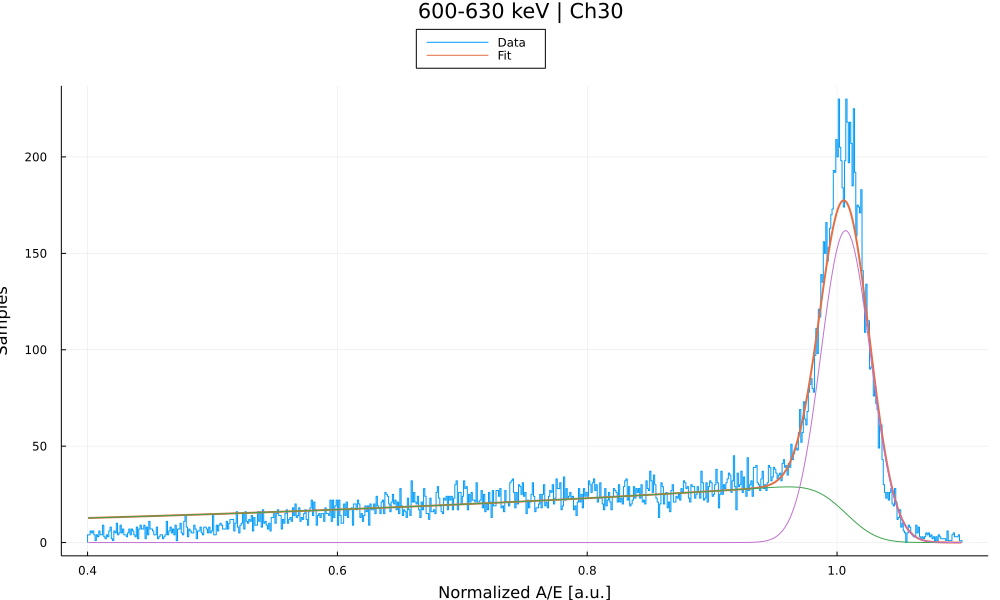

In [729]:
slice_lib_filepath = "../dicts/slice_lib.json"
slice_lib = JSON.parsefile(slice_lib_filepath)
slice = 1
E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
A = deepcopy(data.A)
AoE = A ./ E
AoE ./= calib[ctn[ch]][set]["AE_norm"]
index = findall(x -> x >= slices[slice] && x < slices[slice] + 30, E);
rng_start = 0.5
rng_end = 1.0
h = fit(Histogram, AoE[index], rng_start-0.1:0.001:rng_end+0.1);

par_dict = slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])]["peak"][1]
par = (
    n = par_dict["n"],
    σ = par_dict["σ"],
    μ = par_dict["μ"],
    bkg_l = par_dict["bkg_l"],
    bkg_r = par_dict["bkg_r"],
    c = par_dict["c"],
    d = par_dict["d"],
    β = par_dict["β"]
)
par_dict = slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice])]["peak"][2]
err = (
    n = par_dict["n"],
    σ = par_dict["σ"],
    μ = par_dict["μ"],
    bkg_l = par_dict["bkg_l"],
    bkg_r = par_dict["bkg_r"],
    c = par_dict["c"],
    d = par_dict["d"],
    β = par_dict["β"]
)
if slice > 1
    par_dict = slice_lib[ctn[ch]][set]["AE_slices"][string(slices[slice - 1])]["peak"][1]
    par_old = (
        n = par_dict["n"],
        σ = par_dict["σ"],
        μ = par_dict["μ"],
        bkg_l = par_dict["bkg_l"],
        bkg_r = par_dict["bkg_r"],
        c = par_dict["c"],
        d = par_dict["d"],
        β = par_dict["β"]
    )
end
x_fit = float.(midpoints(h.edges[1]))
y_fit = peak(x_fit, par)
y_fit ./= sum(y_fit)
y_fit .*= sum(h.weights)

par_tail = (n = 0, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = par.c, d = par.d, β = par.β)
y_tail = peak(x_fit, par_tail)
y_tail ./= sum(y_tail)
y_tail .*= (sum(peak(x_fit, par_tail)) / sum(peak(x_fit, par)))
y_tail .*= sum(h.weights)

par_gauss = (n = par.n, σ = par.σ, μ = par.µ, bkg_l = par.bkg_l, bkg_r = par.bkg_r, c = 0, d = par.d, β = par.β)
y_gauss = peak(x_fit, par_gauss)
y_gauss ./= sum(y_gauss)
y_gauss .*= (sum(peak(x_fit, par_gauss)) / sum(peak(x_fit, par)))
y_gauss .*= sum(h.weights)

E_range = string(slices[slice]) * "-" * string(slices[slice] + 30)
p = plot(h, st=:step, label="Data");
p = plot!(x_fit, y_fit, label="Fit", lw=2);
p = plot!(x_fit, y_tail, label="");
p = plot!(x_fit, y_gauss, label="");
p = plot!(xlabel="Normalized A/E [a.u.]", ylabel="Samples", title=E_range * " keV | Ch$ch_str ", legend=:outertop, size=(1000,600));
if slice > 1
    println("n -> ", par_old.n/2, " <= ", par.n, " <= ", par_old.n*2)
    println("σ -> ", par_old.σ/2, " <= ", par.σ, " <= ", par_old.σ*2)
    println("µ -> ", 0.98, " <= ", par.µ, " <= ", 1.02)
    println("bkg_l -> ", par_old.bkg_l/2, " <= ", par.bkg_l, " <= ", par_old.bkg_l*2)
    println("bkg_r -> ", par_old.bkg_r/2, " <= ", par.bkg_r, " <= ", par_old.bkg_r*2)
    println("c -> ", par_old.c/2, " <= ", par.c, " <= ", par_old.c*2)
    println("d -> ", par_old.d/2, " <= ", par.d, " <= ", par_old.d*2)
    println("β -> ", par_old.β/2, " <= ", par.β, " <= ", par_old.β*2)
end
display(p)